# **CHILD AND INFANT MORTALITY ANALYSIS**

## **IMPORTING MODULES**

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

## **READING FILES**

In [26]:
files = {
    "youth_mortality": "dataset/1_youth-mortality-rate.csv",
    "infant_deaths": "dataset/2_number-of-infant-deaths-unwpp.csv",
    "child_mortality_income": "dataset/3_child-mortality-by-income-level-of-country.csv",
    "causes_of_death": "dataset/4_Distribution_of_Causes_of_Death_among_Children_Aged_less_than_5_years.csv",
    "maternal_deaths": "dataset/5_number-of-maternal-deaths-by-region.csv",
    "births_by_staff": "dataset/6_births-attended-by-health-staff-sdgs.csv",
    "vaccination_coverage": "dataset/7_global-vaccination-coverage.csv",
    "health_insurance": "dataset/8_health-protection-coverage.csv"
}

data = {name: pd.read_csv(path) for name, path in files.items()}

## **DATA WRANGLING**

In [14]:
for name, df in data.items():
    data[name] = df.dropna(axis=1, how='all')

if "causes_of_death" in data:
    data["causes_of_death"].drop(columns=["DateModified", "Language"], inplace=True, errors="ignore")

for name, df in data.items():
    data[name] = df.dropna().reset_index(drop=True)

column_renames = {
    "youth_mortality": {"Entity": "Country", "Under-fifteen mortality rate": "Youth Mortality Rate"},
    "infant_deaths": {"Entity": "Country", "Deaths - Sex: all - Age: 0 - Variant: estimates": "Infant Deaths"},
    "child_mortality_income": {"Entity": "Country", "Observation value": "Under-five Mortality Rate"},
    "causes_of_death": {"Location": "Country"},
    "maternal_deaths": {"Entity": "Country", "Estimated maternal deaths": "Maternal Deaths"},
    "births_by_staff": {"Entity": "Country", "Births attended by skilled health staff (% of total)": "Births by Skilled Staff"},
    "health_insurance": {"Entity": "Country", "Share of population covered by health insurance (ILO (2014))": "Health Insurance Coverage"},
    "vaccination_coverage": {"Entity": "Country"}
}

for name, renames in column_renames.items():
    if name in data:
        data[name].rename(columns=renames, inplace=True)

warnings.filterwarnings('ignore')

## **Correlation Analysis**

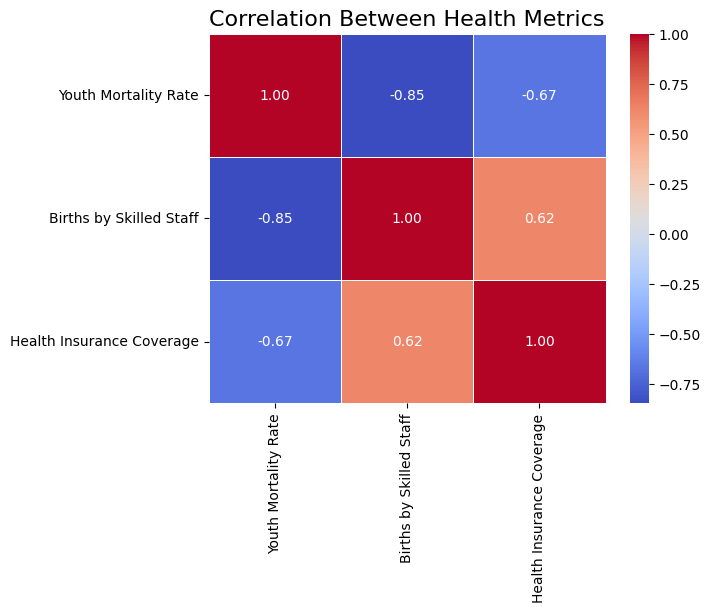

In [15]:
merged = data["youth_mortality"].merge(data["births_by_staff"], on=["Country", "Year"], how="inner")
merged = merged.merge(data["health_insurance"], on=["Country", "Year"], how="inner")

correlation_matrix = merged[["Youth Mortality Rate", "Births by Skilled Staff", "Health Insurance Coverage"]].corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Health Metrics", fontsize=16)
plt.show()


## **Exploratory Data Analysis**

In [16]:
top_mortality_countries = (
    data["youth_mortality"]
    .groupby("Country")["Youth Mortality Rate"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)


## **Identifying High-Risk Regions and Populations**

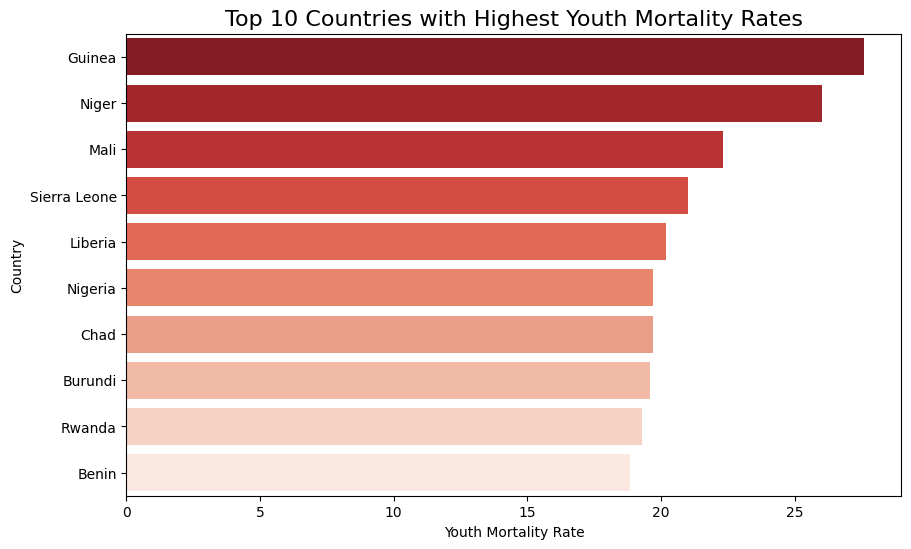

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_mortality_countries.values, y=top_mortality_countries.index, palette="Reds_r")
plt.title("Top 10 Countries with Highest Youth Mortality Rates", fontsize=16)
plt.xlabel("Youth Mortality Rate")
plt.ylabel("Country")
plt.show()

## **Predict Future Trends**

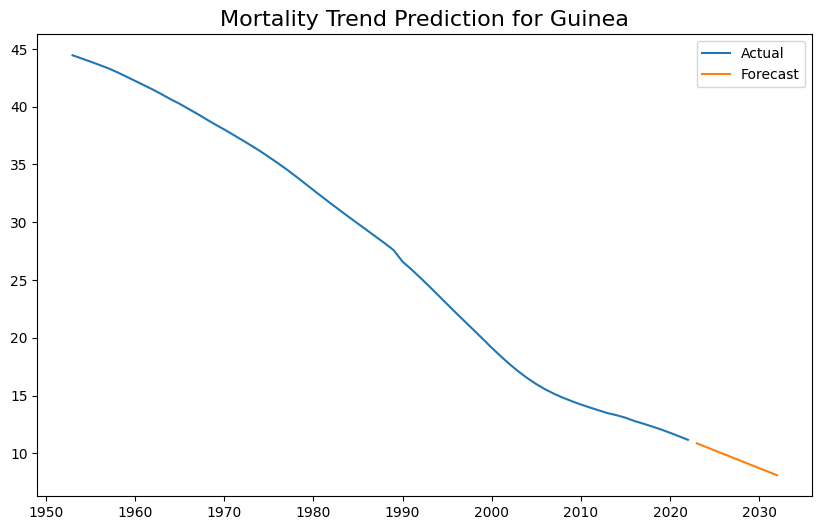

In [18]:
country = top_mortality_countries.index[0]
country_data = data["youth_mortality"].query("Country == @country").sort_values("Year")
model = ExponentialSmoothing(country_data["Youth Mortality Rate"], trend="add", seasonal=None)
fit = model.fit()
forecast = fit.forecast(10)

plt.figure(figsize=(10, 6))
plt.plot(country_data["Year"], country_data["Youth Mortality Rate"], label="Actual")
plt.plot(range(country_data["Year"].max() + 1, country_data["Year"].max() + 11), forecast, label="Forecast")
plt.title(f"Mortality Trend Prediction for {country}", fontsize=16)
plt.legend()
plt.show()

## **Causes of Child Mortality**

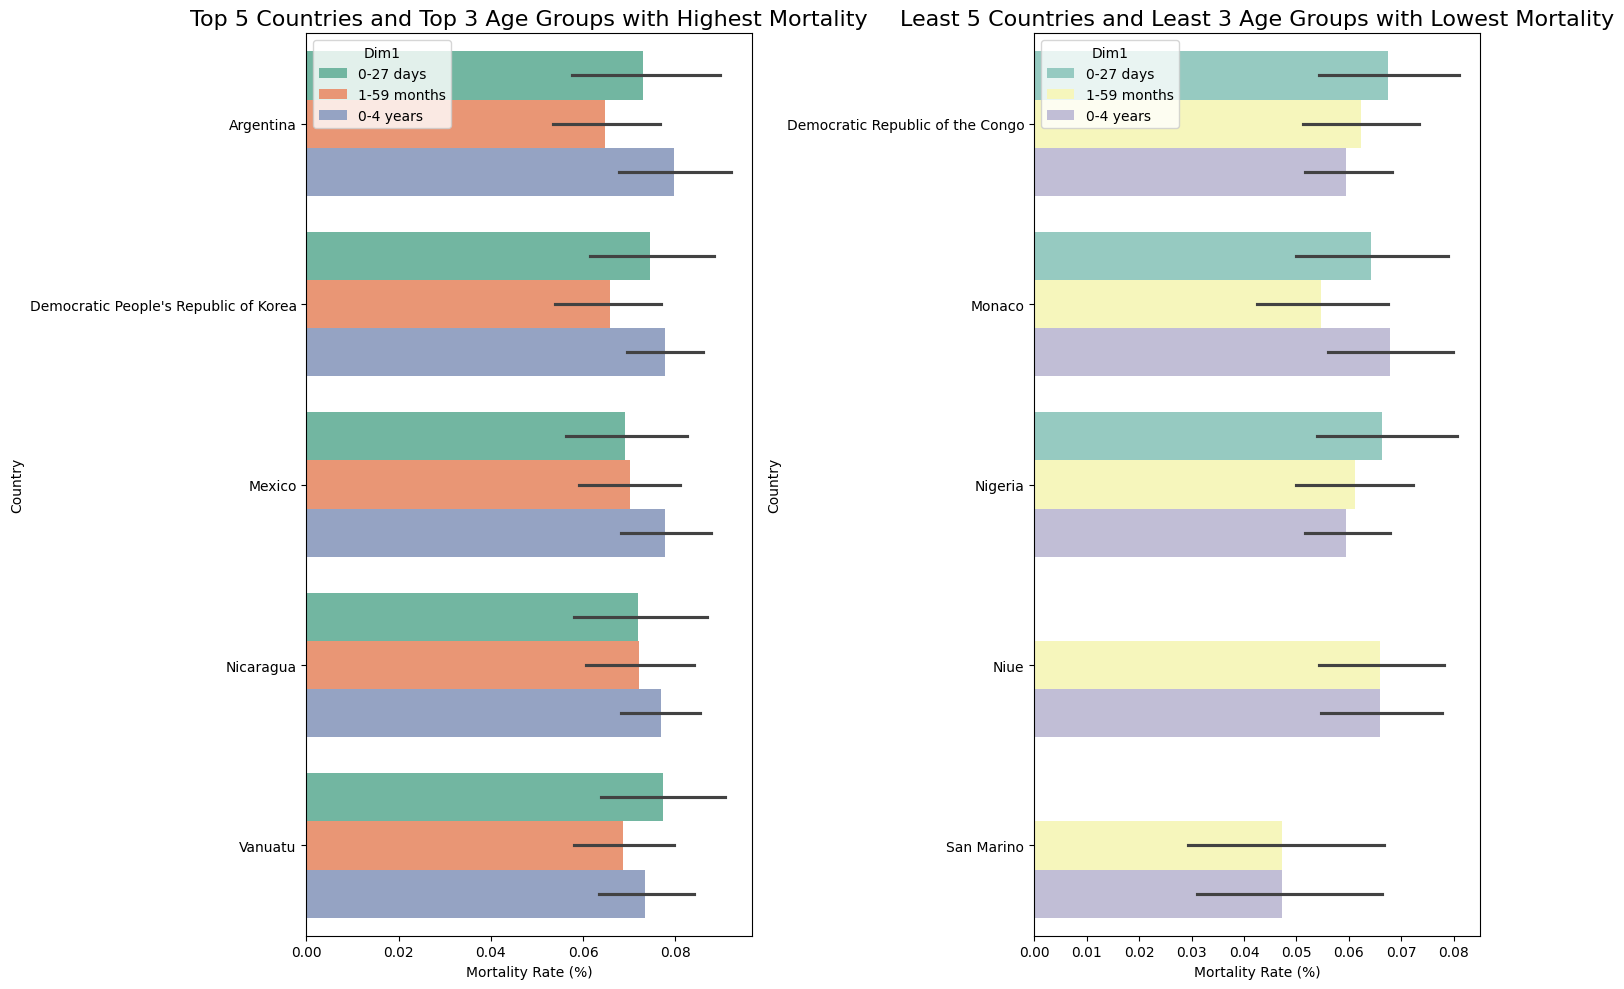

In [19]:
top_countries = data["causes_of_death"].groupby("Country")["Value"].sum().nlargest(5).index
bottom_countries = data["causes_of_death"].groupby("Country")["Value"].sum().nsmallest(5).index
top_age_groups = data["causes_of_death"].groupby("Dim1")["Value"].sum().nlargest(3).index
bottom_age_groups = data["causes_of_death"].groupby("Dim1")["Value"].sum().nsmallest(3).index

# Filter data for top and bottom countries and age groups
top_data = data["causes_of_death"].query("Country in @top_countries and Dim1 in @top_age_groups")
bottom_data = data["causes_of_death"].query("Country in @bottom_countries and Dim1 in @bottom_age_groups")

# Set up a figure with tight layout
plt.figure(figsize=(15, 10))

# Plot for the top countries and top age groups
plt.subplot(1, 2, 1)
sns.barplot(x="Value", y="Country", hue="Dim1", data=top_data, palette="Set2")
plt.title("Top 5 Countries and Top 3 Age Groups with Highest Mortality", fontsize=16)
plt.xlabel("Mortality Rate (%)")
plt.ylabel("Country")
plt.tight_layout()

# Plot for the bottom countries and bottom age groups
plt.subplot(1, 2, 2)
sns.barplot(x="Value", y="Country", hue="Dim1", data=bottom_data, palette="Set3")
plt.title("Least 5 Countries and Least 3 Age Groups with Lowest Mortality", fontsize=16)
plt.xlabel("Mortality Rate (%)")
plt.ylabel("Country")
plt.tight_layout()

plt.show()


## **Evaluating the Effectiveness of Interventions**

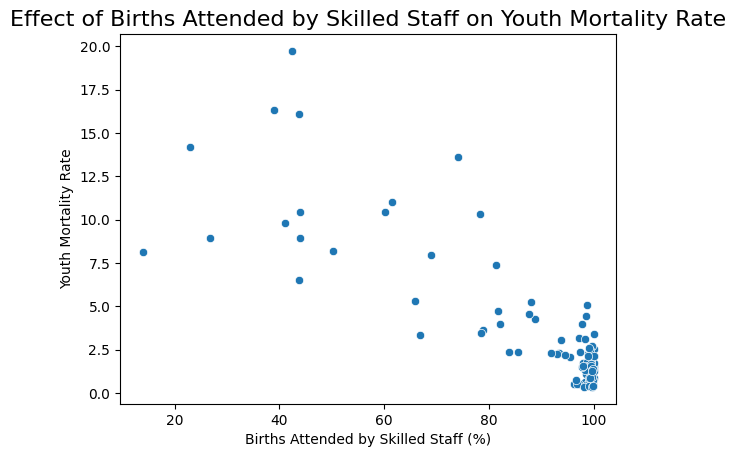

In [20]:
intervention_effect = merged[["Youth Mortality Rate", "Births by Skilled Staff"]]
sns.scatterplot(x="Births by Skilled Staff", y="Youth Mortality Rate", data=intervention_effect)
plt.title("Effect of Births Attended by Skilled Staff on Youth Mortality Rate", fontsize=16)
plt.xlabel("Births Attended by Skilled Staff (%)")
plt.ylabel("Youth Mortality Rate")
plt.show()

## **Developing Data-Driven Strategies**

                           Importance
Births by Skilled Staff       0.89903
Health Insurance Coverage     0.10097


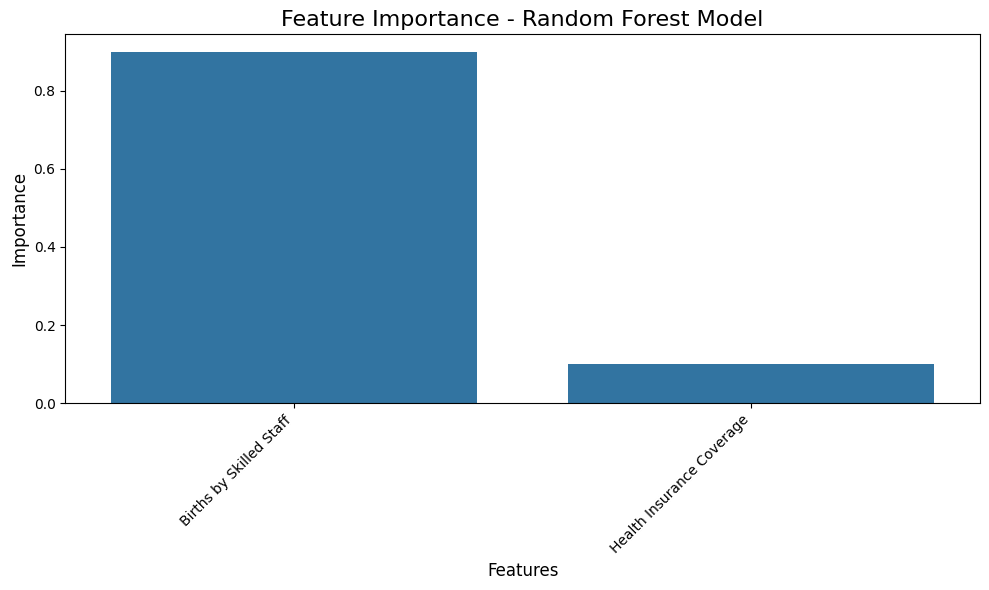

In [21]:
features = ["Births by Skilled Staff", "Health Insurance Coverage", "DTP3 (% of one-year-olds immunized)", "Income Group", "Water Quality"]
missing_columns = [col for col in features if col not in merged.columns]

if missing_columns:
    print(f"Warning: The following columns are missing from the merged DataFrame: {missing_columns}")
    features = [col for col in features if col not in missing_columns]
    
X = merged[features]
y = merged["Youth Mortality Rate"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importance = pd.DataFrame(rf_model.feature_importances_, index=features, columns=["Importance"]).sort_values("Importance", ascending=False)
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.index, y=feature_importance["Importance"])
plt.title("Feature Importance - Random Forest Model", fontsize=16)
plt.ylabel("Importance", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


## **Hyperparameter Tuning and Evaluation of Gradient Boosting Regressor**

Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best Cross-validation Score: 0.693572007225745
Mean Absolute Error (GB): 1.56
R2 Score (GB): 0.68


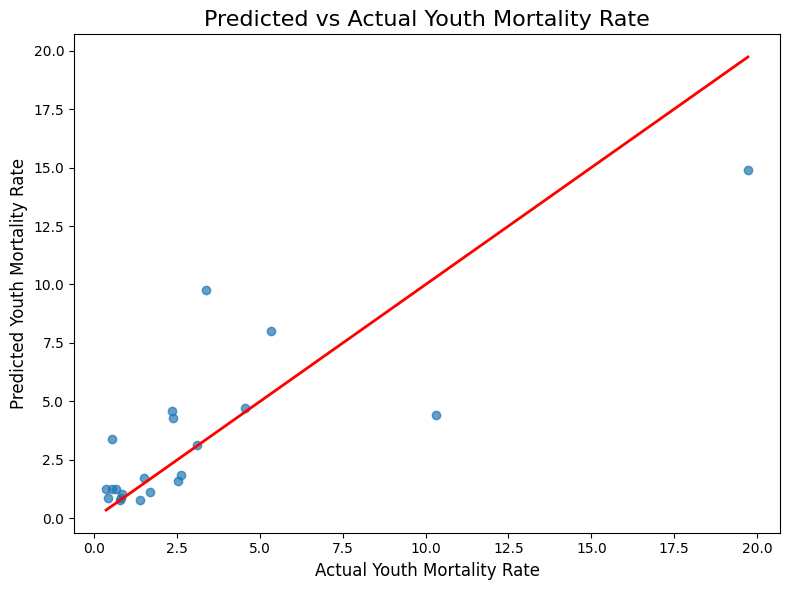

In [22]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 4, 5]
}

gb_model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(gb_model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-validation Score: {grid_search.best_score_}")

y_pred_gb = grid_search.predict(X_test)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Mean Absolute Error (GB): {mae_gb:.2f}")
print(f"R2 Score (GB): {r2_gb:.2f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)  # line of perfect prediction
plt.title("Predicted vs Actual Youth Mortality Rate", fontsize=16)
plt.xlabel("Actual Youth Mortality Rate", fontsize=12)
plt.ylabel("Predicted Youth Mortality Rate", fontsize=12)
plt.tight_layout()
plt.show()